
## SIMD Bitonic Sorting Network

This notebook presents the algorithm that evaluates a Bitonic Sorting Network using the _max_ function and SIMD computations. This approach allows to easily write the same algorithm using the CKKS primitives.

### Importing libraries

The *numpy* library will be useful as it will help us simulate SIMD computations. We also use *math* to compute logarithms and *matplotlib* to plot some numbers

In [137]:
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics

Defining a class to handle Remez approximations

In [138]:
class Chebyshev:
    """
    Chebyshev(a, b, n, func)
    Given a function func, lower and upper limits of the interval [a,b],
    and maximum degree n, this class computes a Chebyshev approximation
    of the function.
    Method eval(x) yields the approximated function value.
    """
    def __init__(self, a, b, n, func):
        self.a = a
        self.b = b
        self.func = func

        bma = 0.5 * (b - a)
        bpa = 0.5 * (b + a)
        f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
        fac = 2.0 / n
        self.c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
                  for k in range(n)]) for j in range(n)]

    def eval(self, x):
        a,b = self.a, self.b
        #assert(a <= x <= b)
        y = (2.0 * x - a - b) * (1.0 / (b - a))
        y2 = 2.0 * y
        (d, dd) = (self.c[-1], 0)             # Special case first step for efficiency
        for cj in self.c[-2:0:-1]:            # Clenshaw's recurrence
            (d, dd) = (y2 * d - dd + cj, d)
        return y * d - dd + 0.5 * self.c[0]   # Last step is different
    
def relu(x):
    return np.maximum(0, x)

def inf_norm(real, approx):
    norm = 0
    for i in range(len(real)):
        diff = abs(real[i] - approx[i])
        if diff > norm:
            norm = diff
    return norm

## Defining primitive functions

This set of functions can be trivially written as CKKS homomorphic operations

In [139]:
def add(a, b):
    """
    Adds two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise sum of input arrays.
    """
    return np.add(a, b)

def add_many(values):
    """
    Sums up multiple arrays contained in the values list.

    Parameters:
    values (list of array-like): List containing arrays to be summed.

    Returns:
    numpy.ndarray: Sum of all arrays in the values list.
    """
    res = np.zeros(len(values[0]), dtype=int)
    for value in values:
        res = add(res, value)
    return res

def sub(a, b):
    """
    Subtracts one array from another element-wise.

    Parameters:
    a (array-like): The array to be subtracted from.
    b (array-like): The array to subtract.

    Returns:
    numpy.ndarray: Element-wise difference of the two input arrays.
    """
    return np.add(a, -b)

def mul(a, b):
    """
    Multiplies two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise product of input arrays.
    """
    return np.multiply(a, b)

def mask(a, index):
    """
    Masks elements of array a at the specified index with 1 and multiplies with the array.

    Parameters:
    a (array-like): The input array.
    index (int): Index to be masked.

    Returns:
    numpy.ndarray: Array with specified index masked with 1.
    """
    mask_vector = np.zeros(len(a), dtype=int)
    mask_vector[index] = 1
    return mul(a, mask_vector)

def rot(a, index):
    """
    Rotates the array to the left by the specified number of positions.

    Parameters:
    a (array-like): The input array.
    index (int): Number of positions to rotate the array to the left.

    Returns:
    numpy.ndarray: Array rotated to the left by the specified number of positions.
    """
    return np.roll(a, -index)

def f_min(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    ans = []
    for i in range(len(a)):
        ans.append(min(a[i], b[i]))
    return np.array(ans)

def f_min_remez(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    ans = []
    for i in range(len(a)):
        ans.append(a[i] - poly_relu_remez.eval(a[i] - b[i]))
    return np.array(ans)

def f_min_cheby(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    return sub(a, np.vectorize(poly_relu_cheby.eval)(sub(a, b)))

Now we define the _swap_ function that will heavily be used throughout the evaluation of the Sorting Network

In [140]:
def swap_simd(a, delta, block = 0, layer = 0, poly = True):    
    """
    Computes a parallel evaluation of a Sorting Network

    Parameters:
    a (array-like): Input array
    delta (int): The value of delta. In a sorting network, it specifies the "length of the arrows".
    r (int): The current round of the sorting network
    s (int): The current stage of the sorting network

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    rot_positive = rot(a, delta)
    rot_negative = rot(a, -delta)
    
    # This is the evaluation of the non-linear function
    
    if poly:
        f = f_min_cheby(a, rot_positive)
    else:
        f = f_min(a, rot_positive)
            
    m1 = f
    m2 = sub(add(a, rot_negative), rot(f, -delta))
    m3 = sub(add(a, rot_positive), f)
    m4 = rot(f, -delta)
    
    masks = generate_masks(len(a), block, layer)
    
    return add_many([mul(m1, masks[0]), 
                     mul(m2, masks[1]),
                     mul(m3, masks[2]),
                     mul(m4, masks[3])])

In [119]:
def generate_masks(n, block, layer):
    """
    Da commentare
    """
    mask_1 = []
    mask_2 = []
    mask_3 = []
    mask_4 = []

    
    print("Masks with {}, {}, {}".format(n, block, layer))

    
    for v in range(int(n / (2 ** (block)))):
        for i in range(2 ** (block - layer)):
            for j in range(2 ** layer):
                if v % 4 == 0:
                    mask_1.append(1)
                else:
                    mask_1.append(0)
                if v % 4 == 1:
                    mask_2.append(1)
                else:
                    mask_2.append(0)
                if v % 4 == 2:
                    mask_3.append(1)
                else:
                    mask_3.append(0)
                if v % 4 == 3:
                    mask_4.append(1)
                else:
                    mask_4.append(0)
    
    return [mask_1, mask_2, mask_3, mask_4]

In [141]:
def generate_masks(length, r, s):
    """
    Da commentare
    """
    mask_1 = []
    mask_2 = []
    mask_3 = []
    mask_4 = []
    
    i = 0  
    
    while (i < length / (2 ** (r + 2))):
        
        for times in range(2 ** s):
            for j in range(2 ** r):
                # How many times do we consider m_1

                mask_1.append(1)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(0)

            for j in range(2 ** r):
                # How many times do we consider m_2

                mask_1.append(0)
                mask_2.append(1)
                mask_3.append(0)
                mask_4.append(0)
        
        # To prevent adding more than required values
        if (i + 1) * 2 ** (s + r + 1) >= length:
            break
            
        for times in range(2 ** s):
            for j in range(2 ** (r)):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(1)
                mask_4.append(0)
                
            for j in range(2 ** r):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(1)
        
            
        if (i + 1) * 2 ** (s + r + 2) >= length:
            break
            
        i += 1
    
    return [mask_1, mask_2, mask_3, mask_4]

In [142]:
len(generate_masks(64, 3, 0)[0])

64

### Evaluating a Network

Let's start with a simple example, ordering two elements

## Sorting 2 elements

In [143]:
n = 2
a = np.arange(n) / n

vec = np.copy(a)

print(vec)

a.sort()

[0.  0.5]


Let's define the approximation with $d = 7$

In [144]:
poly_relu_cheby = Chebyshev(-1, 1, 7, relu)

In [164]:
for b in range(int(math.log2(n))):
    for ell in range(b + 1): 
        delta = 2 ** (b - ell)
        vec = swap_simd(vec, delta, b - ell, ell, poly = True) 
    
print("Before: {}\nAfter: {}".format(a, vec))
print("Infinity norm error: {}".format(inf_norm(a, vec)))
print("Precision bits: {}".format(-math.log2(inf_norm(a, vec))))

Before: [0.5625 0.625  0.375  0.25   0.75   0.125  0.3125 0.4375 0.5    0.9375
 0.8125 0.1875 0.0625 0.875  0.6875 0.    ]
After: [0.01138983 0.07145018 0.11422875 0.17594641 0.2661288  0.32684289
 0.36355382 0.42550966 0.50879925 0.5714045  0.61321954 0.67447894
 0.76331856 0.82472048 0.86465502 0.92435338]
Infinity norm error: 0.9243533769000484
Precision bits: 0.1134836007799865


Now with $d=6$

In [165]:
poly_relu_cheby = Chebyshev(-1, 1, 6, relu)

In [166]:
for b in range(int(math.log2(n))):
    for ell in range(b + 1): 
        delta = 2 ** (b - ell)
        vec = swap_simd(vec, delta, b - ell, ell, poly = True) 
        
print("Before: {}\nAfter: {}".format(a, vec))
print("Infinity norm error: {}".format(inf_norm(a, vec)))
print("Precision bits: {}".format(-math.log2(inf_norm(a, vec))))

Before: [0.5625 0.625  0.375  0.25   0.75   0.125  0.3125 0.4375 0.5    0.9375
 0.8125 0.1875 0.0625 0.875  0.6875 0.    ]
After: [-0.12248267  0.06473521  0.07114623  0.26465712  0.14288275  0.32816179
  0.33354705  0.51298338  0.4244605   0.60388529  0.60933966  0.79462024
  0.67287292  0.86641042  0.8727807   1.05999942]
Infinity norm error: 1.0599994246164868
Precision bits: -0.08406348167227973


Even if the degree is smaller, the approximation has a smaller error with an odd degree.

## Sorting 16 elements

In [167]:
n = 16

a = np.arange(n) / n
np.random.shuffle(a)

vec = np.copy(a)
sorted_a = np.copy(a)
sorted_a.sort()

print(vec)

[0.8125 0.125  0.4375 0.     0.0625 0.875  0.25   0.375  0.1875 0.75
 0.5    0.5625 0.6875 0.9375 0.3125 0.625 ]


In [168]:
vec = np.copy(a)
poly_relu_cheby = Chebyshev(-1, 1, 26, relu)

for b in range(int(math.log2(n))):
    for ell in range(b + 1): 
        delta = 2 ** (b - ell)
        vec = swap_simd(vec, delta, b - ell, ell, poly = True) 
        
#print("Before: {}\nAfter: {}".format(a, vec))
print("Infinity norm error: {}".format(inf_norm(sorted_a, vec)))

Infinity norm error: 0.004528736469582795


In [169]:
vec = np.copy(a)
poly_relu_cheby = Chebyshev(-1, 1, 26, relu)

for b in range(int(math.log2(n))):
    for ell in range(b + 1): 
        delta = 2 ** (b - ell)
        vec = swap_simd(vec, delta, b - ell, ell, poly = True) 
        
#print("Before: {}\nAfter: {}".format(a, vec))
print("Infinity norm error: {}".format(inf_norm(sorted_a, vec)))

Infinity norm error: 0.004528736469582795


In [170]:
vec = np.copy(a)
poly_relu_cheby = Chebyshev(-1, 1, 27, relu)

for b in range(int(math.log2(n))):
    for ell in range(b + 1): 
        delta = 2 ** (b - ell)
        vec = swap_simd(vec, delta, b - ell, ell, poly = True)  
        
#print("Before: {}\nAfter: {}".format(a, vec))
print("Infinity norm error: {}".format(inf_norm(sorted_a, vec)))

Infinity norm error: 0.024558504019257743


We sample a vector of $2^{6} = 64$ elements

In [171]:
n = 2 ** 6

a = np.arange(n) / n
np.random.shuffle(a)

vec = np.copy(a)
print(vec)

[0.46875  0.890625 0.671875 0.96875  0.75     0.828125 0.375    0.40625
 0.296875 0.65625  0.046875 0.515625 0.4375   0.5      0.84375  0.546875
 0.015625 0.6875   0.28125  0.0625   0.625    0.859375 0.203125 0.453125
 0.53125  0.234375 0.90625  0.078125 0.390625 0.9375   0.25     0.875
 0.5625   0.359375 0.984375 0.921875 0.484375 0.703125 0.78125  0.640625
 0.8125   0.       0.578125 0.125    0.796875 0.09375  0.59375  0.328125
 0.765625 0.21875  0.15625  0.71875  0.265625 0.34375  0.3125   0.109375
 0.1875   0.953125 0.609375 0.734375 0.140625 0.421875 0.03125  0.171875]


In [172]:
a_backup = a
a_backup.sort()

Now we evaluate it using SIMD computations, in particular we will just use the _swap_simd_ function

In [173]:
for b in range(int(math.log2(n))):
    for ell in range(b + 1): 
        delta = 2 ** (b - ell)
        vec = swap_simd(vec, delta, b - ell, ell, poly = True) 
        
vec

array([0.0201719 , 0.02033651, 0.03434843, 0.03472841, 0.04047516,
       0.04047531, 0.11019492, 0.11042104, 0.15950885, 0.15983396,
       0.1599656 , 0.16020481, 0.16967933, 0.18511159, 0.24986902,
       0.25173098, 0.25623144, 0.25763929, 0.26148543, 0.26571286,
       0.32292205, 0.33046028, 0.33126817, 0.33368617, 0.42594181,
       0.42633305, 0.42697433, 0.42751823, 0.46126341, 0.46161333,
       0.4625909 , 0.46307497, 0.50502566, 0.50718919, 0.50724514,
       0.50875034, 0.5528302 , 0.55523199, 0.5627135 , 0.59752208,
       0.66096065, 0.67411295, 0.67958894, 0.68143361, 0.71002686,
       0.73346371, 0.74046469, 0.7411421 , 0.74551482, 0.74702466,
       0.75404932, 0.75429085, 0.76586998, 0.83715846, 0.85411459,
       0.8768171 , 0.91187092, 0.91481638, 0.9155505 , 0.9173819 ,
       0.93104857, 0.94139475, 0.9462828 , 0.94734124])

In [132]:
precision_bits = {}

for deg in range(1, 119):
    poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
    vec = np.copy(a)
    for i in range(int(math.log2(n))):
        for j in range(i + 1): 
            delta = 2 ** (i - j)
            s = i - j
            r = j
            vec = swap_simd(vec, delta, s, r, poly = True)  
    print("Precision bits for d = {}: {}".format(deg, inf_norm(a_backup, vec)))

Precision bits for d = 1: 0.4843750000000002
Precision bits for d = 2: 1.6291328435596428
Precision bits for d = 3: 0.34076003146893347
Precision bits for d = 4: 8134.969099320469
Precision bits for d = 5: 0.22529849878822833
Precision bits for d = 6: 0.29767839072788504
Precision bits for d = 7: 0.1771097464933894
Precision bits for d = 8: nan
Precision bits for d = 9: 0.17117267999905827
Precision bits for d = 10: 0.7022104412538828
Precision bits for d = 11: 0.12850119924294767
Precision bits for d = 12: nan
Precision bits for d = 13: 0.10872081561053448
Precision bits for d = 14: 0.5128262767708944
Precision bits for d = 15: 0.10972897503152323
Precision bits for d = 16: nan
Precision bits for d = 17: 0.09992097977546938
Precision bits for d = 18: 0.14294800975454341
Precision bits for d = 19: 0.09343786263166876
Precision bits for d = 20: 0.589011830179939
Precision bits for d = 21: 0.08480453403196098
Precision bits for d = 22: 0.04777365560231983
Precision bits for d = 23: 0.069

/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_8006/2655396399.py:28: RuntimeWarning: overflow encountered in scalar multiply
  (d, dd) = (y2 * d - dd + cj, d)
/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_8006/2655396399.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  (d, dd) = (y2 * d - dd + cj, d)


Precision bits for d = 43: 0.045356038998743076
Precision bits for d = 44: 0.016300248593936972
Precision bits for d = 45: 0.041067562643700595
Precision bits for d = 46: 0.014901913439256842
Precision bits for d = 47: 0.035343411495496024
Precision bits for d = 48: 0.013421276869134635
Precision bits for d = 49: 0.028967708768352862
Precision bits for d = 50: 0.012601398061218294
Precision bits for d = 51: 0.025023326918975464
Precision bits for d = 52: 0.011917506682598944
Precision bits for d = 53: 0.027264236191826052
Precision bits for d = 54: 0.011153216528643428
Precision bits for d = 55: 0.02984999540691452
Precision bits for d = 56: 0.010353254181480143
Precision bits for d = 57: 0.03137386529246072
Precision bits for d = 58: 0.009670089870656817
Precision bits for d = 59: 0.03212231846051117
Precision bits for d = 60: 0.00897597249872567
Precision bits for d = 61: 0.03218189019109241
Precision bits for d = 62: 0.0082819519106907
Precision bits for d = 63: 0.03231441879590202


In [131]:
precision_bits = {}

for deg in range(10, 119):
    poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
    vec = np.copy(a)
    for i in range(int(math.log2(n))):
        for j in range(i + 1): 
            delta = 2 ** (i - j)
            s = i - j
            r = j
            vec = swap_simd(vec, delta, s, r, poly = True)  
    print("Precision bits for d = {}: {}".format(deg, round(-math.log2(max(abs(a_backup - vec))), 2)))
    precision_bits[deg] = round(-math.log2(max(abs(sub(a_backup, vec)))), 2)
    

Precision bits for d = 10: 0.51
Precision bits for d = 11: 2.96
Precision bits for d = 12: nan
Precision bits for d = 13: 3.2
Precision bits for d = 14: 0.96
Precision bits for d = 15: 3.19
Precision bits for d = 16: nan
Precision bits for d = 17: 3.32
Precision bits for d = 18: 2.81
Precision bits for d = 19: 3.42
Precision bits for d = 20: 0.76
Precision bits for d = 21: 3.56
Precision bits for d = 22: 4.39
Precision bits for d = 23: 3.85
Precision bits for d = 24: 1.73
Precision bits for d = 25: 4.1
Precision bits for d = 26: 4.81
Precision bits for d = 27: 4.12
Precision bits for d = 28: 2.8
Precision bits for d = 29: 4.06
Precision bits for d = 30: 5.12
Precision bits for d = 31: 4.06
Precision bits for d = 32: 4.1
Precision bits for d = 33: 4.09
Precision bits for d = 34: 5.46
Precision bits for d = 35: 4.14
Precision bits for d = 36: 5.28
Precision bits for d = 37: 4.17
Precision bits for d = 38: 5.63
Precision bits for d = 39: 4.26
Precision bits for d = 40: 5.71
Precision bits

/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_8006/2655396399.py:28: RuntimeWarning: overflow encountered in scalar multiply
  (d, dd) = (y2 * d - dd + cj, d)
/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_8006/2655396399.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  (d, dd) = (y2 * d - dd + cj, d)


Precision bits for d = 45: 4.61
Precision bits for d = 46: 6.07
Precision bits for d = 47: 4.82
Precision bits for d = 48: 6.22
Precision bits for d = 49: 5.11
Precision bits for d = 50: 6.31
Precision bits for d = 51: 5.32
Precision bits for d = 52: 6.39
Precision bits for d = 53: 5.2
Precision bits for d = 54: 6.49
Precision bits for d = 55: 5.07
Precision bits for d = 56: 6.59
Precision bits for d = 57: 4.99
Precision bits for d = 58: 6.69
Precision bits for d = 59: 4.96
Precision bits for d = 60: 6.8
Precision bits for d = 61: 4.96
Precision bits for d = 62: 6.92
Precision bits for d = 63: 4.95
Precision bits for d = 64: 7.04
Precision bits for d = 65: 4.95
Precision bits for d = 66: 7.15
Precision bits for d = 67: 4.97
Precision bits for d = 68: 7.22
Precision bits for d = 69: 5.02
Precision bits for d = 70: 7.3
Precision bits for d = 71: 5.07
Precision bits for d = 72: 7.38
Precision bits for d = 73: 5.13
Precision bits for d = 74: 7.47
Precision bits for d = 75: 5.18
Precision b

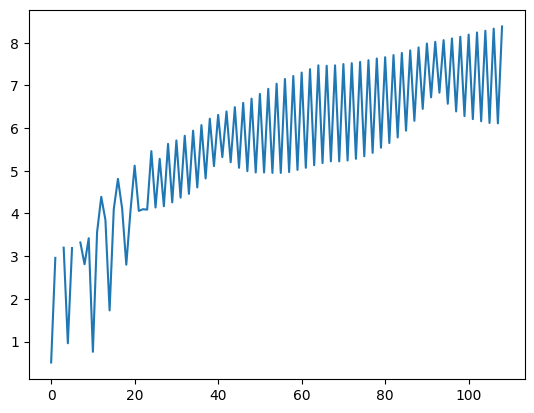

In [107]:
plt.plot(list(precision_bits.values()))

In [108]:
print("Real sorted: {}\nPoly sorted: {}".format(a * n, vec * n))

Real sorted: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
Poly sorted: [ 0.17822862  1.05981519  1.92193531  2.81593646  4.19228285  5.08699947
  5.94766548  6.84803578  8.15235235  9.05235661  9.91312791 10.80905681
 12.18283858 13.08068306 13.93841604 14.8470916  16.15299088 17.06142543
 17.91940536 18.81733914 20.19073218 21.0867866  21.94783445 22.84745877
 24.15246898 25.05209889 25.91312712 26.80858322 28.18165425 29.08217293
 29.93392041 30.8541186  32.1458814  33.06607959 33.91782707 34.81834575
 36.19141678 37.08687288 37.94790111 38.84753102 40.15254123 41.05216555
 41.9132134  42.80926782 44.18266086 45.08059464 45.93857457 46.84700912
 48.1529084  49.06158396 49.91931694 50.81716142 52.19094319 53.08687209
 53.94764339 54.84764765 56.15196422 57.05233452 57.9130

Distribution of errors

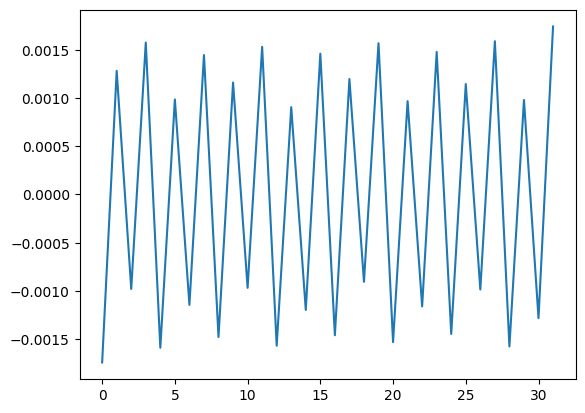

In [66]:
plt.plot(sub(a, vec))

## Experiment 1 - Even-size heuristic

In [41]:
n = 4

a = np.array([0.5, 0.5001, 0.5002, 0.5003])
np.random.shuffle(a)

vec = np.copy(a)
print(vec)

a_backup = a
a_backup.sort()

[0.5003 0.5001 0.5    0.5002]


In [42]:
deg = 40
vec = np.copy(a)

poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, poly = True)  
print("Precision bits for d = {}: {}".format(deg, -math.log2(inf_norm(a_backup, vec))))

Precision bits for d = 40: 5.166611843023754


In [43]:
deg = 41
vec = np.copy(a)

poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, poly = True)  
print("Precision bits for d = {}: {}".format(deg, -math.log2(inf_norm(a_backup, vec))))

Precision bits for d = 41: 12.70623180399145


In [44]:
n = 4

a = np.array([0.00, 0.25, 0.50, 0.75])
np.random.shuffle(a)

vec = np.copy(a)
print(vec)

a_backup = a
a_backup.sort()

[0.25 0.   0.5  0.75]


In [45]:
deg = 40
vec = np.copy(a)

poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, poly = True)  
print("Precision bits for d = {}: {}".format(deg, -math.log2(inf_norm(a_backup, vec))))

Precision bits for d = 40: 11.076450127677305


In [46]:
deg = 41
vec = np.copy(a)

poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, poly = True)  
print("Precision bits for d = {}: {}".format(deg, -math.log2(inf_norm(a_backup, vec))))

Precision bits for d = 41: 8.290003386435636


In [50]:
n = 2 ** 2

a = np.random.random((n))
np.random.shuffle(a)

vec = np.copy(a)
print(vec)

a_backup = a
a_backup.sort()

[0.07800581 0.51865547 0.95707994 0.61176562]


In [29]:
odd_precisions = []
even_precisions = []

for i in range(500):
    n = 2 ** 3

    a = np.random.random((n))
    np.random.shuffle(a)

    vec = np.copy(a)

    a_backup = a
    a_backup.sort()
    
    deg = 40
    vec = np.copy(a)

    poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
    for i in range(int(math.log2(n))):
        for j in range(i + 1): 
            delta = 2 ** (i - j)
            s = i - j
            r = j
            vec = swap_simd(vec, delta, s, r, poly = True)  
    print("Precision bits for d = {}: {}".format(deg, -math.log2(inf_norm(a_backup, vec))))
    even_precisions.append(-math.log2(inf_norm(a_backup, vec)))

    deg = 41
    vec = np.copy(a)

    poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
    for i in range(int(math.log2(n))):
        for j in range(i + 1): 
            delta = 2 ** (i - j)
            s = i - j
            r = j
            vec = swap_simd(vec, delta, s, r, poly = True)  
    print("Precision bits for d = {}: {}".format(deg, -math.log2(inf_norm(a_backup, vec))))
    odd_precisions.append(-math.log2(inf_norm(a_backup, vec)))
    
    print("**")

Precision bits for d = 40: 7.198191062521224
Precision bits for d = 41: 5.605501054103633
**
Precision bits for d = 40: 6.705995464192529
Precision bits for d = 41: 5.581613061684045
**
Precision bits for d = 40: 5.957411055963791
Precision bits for d = 41: 6.923496076336512
**
Precision bits for d = 40: 6.934663727156094
Precision bits for d = 41: 6.2092619086665914
**
Precision bits for d = 40: 6.849379813433553
Precision bits for d = 41: 5.35678929989267
**
Precision bits for d = 40: 5.922947663546374
Precision bits for d = 41: 5.687528871639376
**
Precision bits for d = 40: 6.363408521794135
Precision bits for d = 41: 6.676963494184481
**
Precision bits for d = 40: 6.715119885135244
Precision bits for d = 41: 5.198000662418587
**
Precision bits for d = 40: 6.571443706843119
Precision bits for d = 41: 6.426772125986117
**
Precision bits for d = 40: 6.281224112314174
Precision bits for d = 41: 5.448563181978638
**
Precision bits for d = 40: 6.115904352410125
Precision bits for d = 41

Precision bits for d = 41: 5.619617115603246
**
Precision bits for d = 40: 6.759479105992765
Precision bits for d = 41: 6.222970137407975
**
Precision bits for d = 40: 5.349326910507686
Precision bits for d = 41: 6.067241192568591
**
Precision bits for d = 40: 7.310830947754422
Precision bits for d = 41: 5.659859454021165
**
Precision bits for d = 40: 6.239975486184659
Precision bits for d = 41: 5.895058788018615
**
Precision bits for d = 40: 8.667710752737026
Precision bits for d = 41: 6.103073702282924
**
Precision bits for d = 40: 7.699590618718409
Precision bits for d = 41: 6.010911131752115
**
Precision bits for d = 40: 7.348126671578868
Precision bits for d = 41: 5.624257823851986
**
Precision bits for d = 40: 6.161791144962308
Precision bits for d = 41: 5.5101116977005224
**
Precision bits for d = 40: 6.410572997908294
Precision bits for d = 41: 5.930778659841886
**
Precision bits for d = 40: 8.008549148540492
Precision bits for d = 41: 5.660443378214232
**
Precision bits for d 

Precision bits for d = 40: 7.439379753874132
Precision bits for d = 41: 5.456802189632782
**
Precision bits for d = 40: 9.257242826469716
Precision bits for d = 41: 5.205277255259985
**
Precision bits for d = 40: 6.581008303406473
Precision bits for d = 41: 5.82658231948653
**
Precision bits for d = 40: 6.9022327473906175
Precision bits for d = 41: 5.683759800605425
**
Precision bits for d = 40: 6.177535697227153
Precision bits for d = 41: 6.466365921285515
**
Precision bits for d = 40: 6.14540161731134
Precision bits for d = 41: 5.351261482699721
**
Precision bits for d = 40: 5.965699633078352
Precision bits for d = 41: 5.504304761336235
**
Precision bits for d = 40: 7.940503674386461
Precision bits for d = 41: 5.739840956884513
**
Precision bits for d = 40: 8.89788189237498
Precision bits for d = 41: 5.322753473169646
**
Precision bits for d = 40: 5.896996668603808
Precision bits for d = 41: 5.542147347855382
**
Precision bits for d = 40: 6.19048927940614
Precision bits for d = 41: 4

In [30]:
print("Odd precisions mean: {}\nEven precisions mean: {}".format(sum(odd_precisions)/ len(odd_precisions), sum(even_precisions) / len(even_precisions)))
print("Odd precisions stdev: {}\nEven precisions stdev: {}".format(statistics.stdev(odd_precisions), statistics.stdev(even_precisions)))

Odd precisions mean: 5.810098648234554
Even precisions mean: 6.678076990931891
Odd precisions stdev: 0.44160310514254875
Even precisions stdev: 0.7220154575560261
